In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import io
import numpy as np
import scipy
from scipy import stats 
from tensorflow import keras
from matplotlib.pyplot import figure
from google.colab import files
from __future__ import absolute_import, division, print_function
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# ignore SettingWithCopyWarning errors
pd.options.mode.chained_assignment = None  

In [22]:
# upload the dataset to Google Colaboratory and read the dataset
uploaded = files.upload()
import_data = pd.read_csv(io.BytesIO(uploaded['Gisborne_Aws_2810_Imputed.csv']), na_values=('-'))

# convert date to datetime type so dates can be processed
import_data['Day_Local_Date']=pd.to_datetime(import_data.Day_Local_Date)
data=import_data

Saving Gisborne_Aws_2810_Imputed.csv to Gisborne_Aws_2810_Imputed (1).csv


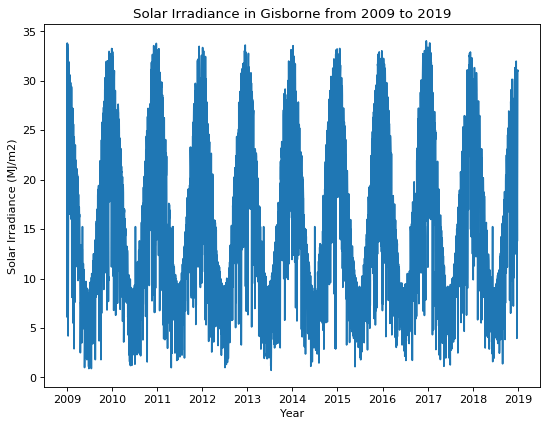

In [23]:
# set global figure size to 8 inches x 6 inches
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# plot solar irradiance against year to confirm expected seasonal trends are present
plt.plot(data['Day_Local_Date'], data['Rad_MJ/m2'])
plt.xlabel("Year")
plt.ylabel("Solar Irradiance (MJ/m2)")
plt.title("Solar Irradiance in Gisborne from 2009 to 2019")
plt.show()

In [0]:
# convert date to numeric so dates can be handled properly
data['Day_Local_Date']=pd.to_datetime(data.Day_Local_Date)
data['Day_Local_Date']=pd.to_numeric(data.Day_Local_Date)

In [25]:
# standardized_data=data-data.mean()/data.std()
# standardized_data=data/data.max()

# create a set of normalized data 
normalized_data = (data - data.min()) / (data.max() - data.min())

# find the correlation coefficient between each feature in the data
normalized_data.corr()


,Day_Local_Date,WDir_Deg,WSpd_m/s,GustDir_Deg,GustSpd_m/s,WindRun_Km,Rain_mm,Tdry_C,TWet_C,RH_%,Tmax_C,Tmin_C,Tgmin_C,Pmsl_hPa,Rad_MJ/m2,Evaporation_Amount_mm,Sun_hrs
Day_Local_Date,1.000000,-0.002405,0.003373,0.011030,0.007034,0.011288,-0.016657,0.034028,0.007071,-0.094603,0.025553,0.011787,0.030842,-0.032800,0.001072,0.018097,0.045454
WDir_Deg,-0.002405,1.000000,0.112422,0.301025,-0.080764,0.009389,-0.185288,-0.080789,-0.144580,-0.135623,0.107351,-0.206886,-0.272048,0.005544,0.144312,0.040063,0.316774
WSpd_m/s,0.003373,0.112422,1.000000,0.282543,0.573695,0.557805,-0.016810,0.105299,-0.068083,-0.504792,-0.017090,0.098502,0.115601,-0.289353,0.062938,0.170368,0.078538
GustDir_Deg,0.011030,0.301025,0.282543,1.000000,0.234572,0.321969,-0.180237,-0.024337,-0.133511,-0.283949,0.092015,-0.106118,-0.138021,-0.238917,-0.006320,0.004532,0.184999
GustSpd_m/s,0.007034,-0.080764,0.573695,0.234572,1.000000,0.814264,0.124779,0.223121,0.095497,-0.428868,0.059886,0.212101,0.220760,-0.482715,0.006546,0.180333,-0.049100
WindRun_Km,0.011288,0.009389,0.557805,0.321969,0.814264,1.000000,0.105547,0.194817,0.062044,-0.428137,0.093690,0.142274,0.136349,-0.396353,0.087486,0.201980,0.065132
Rain_mm,-0.016657,-0.185288,-0.016810,-0.180237,0.124779,0.105547,1.000000,-0.030920,0.042446,0.217116,-0.164090,0.073989,0.125729,-0.097418,-0.309855,-0.115262,-0.373830
Tdry_C,0.034028,-0.080789,0.105299,-0.024337,0.223121,0.194817,-0.030920,1.000000,0.945085,-0.426638,0.849245,0.856725,0.751638,-0.223902,0.557424,0.688491,0.256975
TWet_C,0.007071,-0.144580,-0.068083,-0.133511,0.095497,0.062044,0.042446,0.945085,1.000000,-0.112431,0.810344,0.871572,0.788811,-0.157180,0.441096,0.562659,0.128314
RH_%,-0.094603,-0.135623,-0.504792,-0.283949,-0.428868,-0.428137,0.217116,-0.426638,-0.112431,1.000000,-0.326597,-0.192815,-0.104870,0.254730,-0.468099,-0.523034,-0.420174


In [26]:
# split the normalized data into 80% training data and 20% validation data
train_set, test_set = train_test_split(normalized_data, test_size=0.2, random_state=42)

# confirm the training and validation datasets follow an 80%-20% split
train_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 2787 to 3174
Data columns (total 17 columns):
Day_Local_Date           2921 non-null float64
WDir_Deg                 2921 non-null float64
WSpd_m/s                 2921 non-null float64
GustDir_Deg              2921 non-null float64
GustSpd_m/s              2921 non-null float64
WindRun_Km               2921 non-null float64
Rain_mm                  2921 non-null float64
Tdry_C                   2921 non-null float64
TWet_C                   2921 non-null float64
RH_%                     2921 non-null float64
Tmax_C                   2921 non-null float64
Tmin_C                   2921 non-null float64
Tgmin_C                  2921 non-null float64
Pmsl_hPa                 2921 non-null float64
Rad_MJ/m2                2921 non-null float64
Evaporation_Amount_mm    2921 non-null float64
Sun_hrs                  2921 non-null float64
dtypes: float64(17)
memory usage: 410.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index

In [27]:
# Feature to predict is solar irradiance - pop it from both datasets
strat_train_labels = train_set.pop('Rad_MJ/m2')
strat_test_labels = test_set.pop('Rad_MJ/m2')

# confirm the Train dataset consists of random values (check index numbers)
train_set[:10]

,Day_Local_Date,WDir_Deg,WSpd_m/s,GustDir_Deg,GustSpd_m/s,WindRun_Km,Rain_mm,Tdry_C,TWet_C,RH_%,Tmax_C,Tmin_C,Tgmin_C,Pmsl_hPa,Evaporation_Amount_mm,Sun_hrs
2787,0.763353,0.875000,0.114286,0.440111,0.215190,0.204286,0.018325,0.300,0.333333,0.858407,0.228669,0.334728,0.446043,0.846975,0.126214,0.375000
2991,0.819228,0.563889,0.066667,0.955432,0.042194,0.107143,0.109948,0.728,0.869565,0.955752,0.569966,0.782427,0.884892,0.448399,0.223301,0.000000
2287,0.626404,0.922222,0.457143,0.883008,0.455696,0.430000,0.000000,0.756,0.743961,0.530973,0.617747,0.539749,0.571942,0.718861,0.203883,0.583333
1414,0.387291,0.947222,0.361905,0.905292,0.261603,0.195714,0.002618,0.516,0.454106,0.436578,0.488055,0.255230,0.280576,0.448399,0.174757,0.534722
2864,0.784443,0.836111,0.361905,0.454039,0.303797,0.290000,0.000000,0.540,0.449275,0.342183,0.402730,0.472803,0.535971,0.345196,0.504854,0.458333
990,0.271159,0.944444,0.285714,0.233983,0.172996,0.200000,0.001309,0.324,0.333333,0.747788,0.337884,0.179916,0.197842,0.514235,0.281553,0.368056
2234,0.611887,0.875000,0.104762,0.462396,0.172996,0.151429,0.000000,0.564,0.628019,0.814159,0.505119,0.631799,0.715827,0.701068,0.242718,0.645833
2356,0.645303,0.805556,0.371429,0.582173,0.388186,0.250000,0.040576,0.416,0.352657,0.451327,0.286689,0.334728,0.413669,0.516014,0.213592,0.263889
1362,0.373048,0.861111,0.200000,0.334262,0.172996,0.131429,0.000000,0.348,0.318841,0.589971,0.249147,0.184100,0.233813,0.822064,0.242718,0.451389
576,0.157765,0.913889,0.323810,0.888579,0.215190,0.168571,0.000000,0.136,0.140097,0.868732,0.290102,0.096234,0.129496,0.941281,0.067961,0.527778


In [0]:
# define the neural network configuration
def build_model():
    model = keras.Sequential([
        tf.keras.layers.Dense(150, activation=tf.nn.relu, input_shape=[len(train_set.keys())]),   # input layer
        tf.keras.layers.Dense(100, activation=tf.nn.relu),                                        # hidden layers
        tf.keras.layers.Dense(100, activation=tf.nn.relu),                                        # hidden layers
        tf.keras.layers.Dense(100, activation=tf.nn.relu),                                        # hidden layers
        tf.keras.layers.Dense(1)                                                                  # output layer (only 1 value output)
    ])

    # implement learning algorithm with corresponding learning rate
    optimizer = tf.keras.optimizers.Adam(0.001) 
    
    # define the loss function, optimizer and metrics used to evaluate prediction performance
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error','acc'])
    return model


In [0]:
# build the model
model = build_model()


In [30]:
# confirm the network configuration has been built as specified
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 150)               2550      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 37,951
Trainable params: 37,951
Non-trainable params: 0
_________________________________________________________________


In [0]:
# stop the model from learning when there is no improvement in error after
# a certain amount of epochs 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto')

# display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None): 
      i=0
      if (epoch % 100 == 0):
            print('')
      print('*', end='')

In [32]:

# total number of epochs 
EPOCHS = 500

# train the model for a given number of epochs 
# Train dataset split into 80% data is used to train the model
# Train dataset split into 20% data is used to validate model predictions
history = model.fit(train_set, strat_train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0,
                     callbacks=[early_stop, PrintDot()])



****************

In [0]:
# plot the RMSE and MAE over epochs during training
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Radiation]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')

  plt.ylim([0,.25])
  plt.legend()
  plt.title("Mean Absolute Error during training over epochs for Gisborne")
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Radiation^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.title("Mean Squared Error during training over epochs for Gisborne")
  plt.show()

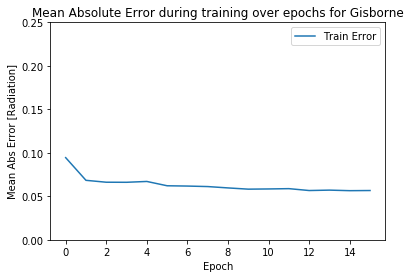

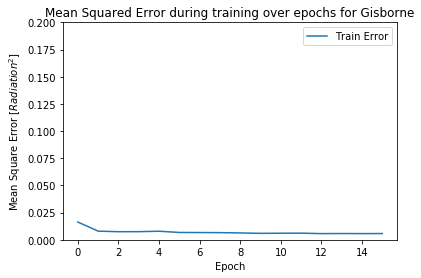

In [34]:
# show the graphs 
plot_history(history)

In [35]:
# evaluate how well model generalizes to new data by using the test set
loss, mae, mse, acc = model.evaluate(test_set, strat_test_labels, verbose=0)
print('')
print("Testing Mean Absolute Error of the Test data set: {:2.2f} ".format(mae))

# use the trained model to predict measurements in the Train and Validation datasets
test_predictions = model.predict(test_set).flatten()
train_predictions = model.predict(train_set).flatten()


Testing Mean Absolute Error of the Test data set: 0.06 


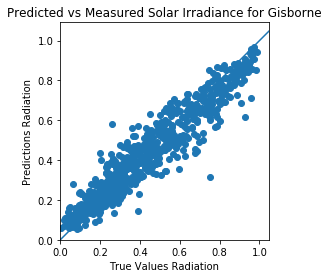

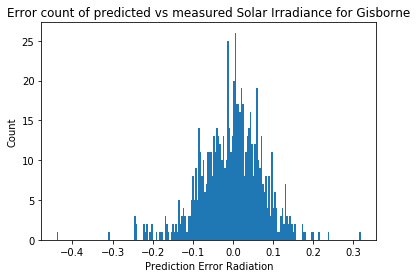

In [36]:
# create a scatter plot
plt.scatter(strat_test_labels, test_predictions)      
plt.xlabel('True Values Radiation')                
plt.ylabel('Predictions Radiation')                 
plt.axis('equal')                               # x and y axes have equal scaling
plt.axis('square')                              # square plot
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.title("Predicted vs Measured Solar Irradiance for Gisborne")
plt.show()

# create a histogram of the error distribution
error = test_predictions - strat_test_labels  # error = difference between predictions and labels
plt.hist(error, bins=200)                     # compute a histogram of error
plt.xlabel("Prediction Error Radiation")
_ = plt.ylabel("Count")
plt.title("Error count of predicted vs measured Solar Irradiance for Gisborne")
plt.show()

In [37]:
test_set['Predicted_Radiation']=test_predictions
test_set['Actual_Radiation']=strat_test_labels

data['Day_Local_Date'].max()
test_set['Day_Local_Date']=test_set.Day_Local_Date*data['Day_Local_Date'].max()
test_set['Day_Local_Date']=pd.to_datetime(test_set.Day_Local_Date)

train_set['Predicted_Radiation']=train_predictions

train_set['Actual_Radiation']=strat_train_labels

train_set['Day_Local_Date']=train_set.Day_Local_Date*data['Day_Local_Date'].max()
train_set['Day_Local_Date']=pd.to_datetime(train_set.Day_Local_Date)
train_set.head()

combinedTraintest=train_set.append(test_set,sort='True')
combinedTraintest=combinedTraintest.sort_index()
combinedTraintest.head()
# combinedTraintest['Actual_Radiation']=combinedTraintest['Actual_Radiation']*import_data['Rad_MJ/m2'].max()
# combinedTraintest['Predicted_Radiation']=combinedTraintest['Predicted_Radiation']*import_data['Rad_MJ/m2'].max()

,Actual_Radiation,Day_Local_Date,Evaporation_Amount_mm,GustDir_Deg,GustSpd_m/s,Pmsl_hPa,Predicted_Radiation,RH_%,Rain_mm,Sun_hrs,TWet_C,Tdry_C,Tgmin_C,Tmax_C,Tmin_C,WDir_Deg,WSpd_m/s,WindRun_Km
0,0.894026,1970-01-01 00:00:00.000000000,0.747573,0.749304,0.388186,0.432384,0.890120,0.219764,0.000000,0.875000,0.748792,0.892,0.845324,0.747440,0.874477,0.805556,0.485714,0.397143
1,0.939057,1970-01-05 21:38:24.354971240,0.805825,0.832869,0.518987,0.565836,0.990909,0.143068,0.000000,0.923611,0.724638,0.908,0.726619,0.795222,0.761506,1.000000,0.342857,0.565714
2,0.161513,1970-01-10 19:16:48.709942481,0.873786,0.888579,0.476793,0.498221,0.204396,0.544248,0.027487,0.000000,0.864734,0.860,0.967626,0.638225,0.958159,0.944444,0.342857,0.392857
3,0.993095,1970-01-15 16:55:13.064913722,0.291262,0.387187,0.236287,0.629893,0.902026,0.467552,0.000000,0.951389,0.560386,0.608,0.413669,0.515358,0.476987,0.916667,0.200000,0.205714
4,0.921045,1970-01-20 14:33:37.419884963,0.592233,0.275766,0.345992,0.679715,0.959100,0.529499,0.000000,0.937500,0.652174,0.672,0.410072,0.610922,0.426778,0.944444,0.142857,0.251429


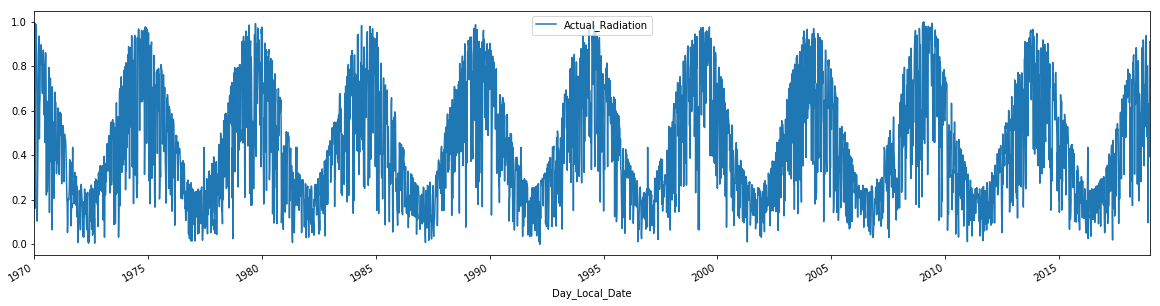

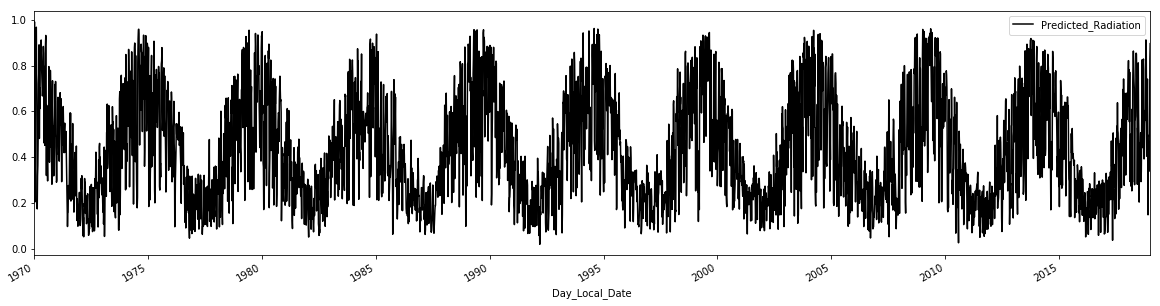

In [38]:
# plot measured vs predicted solar irradiance to confirm trends are similar
combinedTraintest.plot(x='Day_Local_Date', y='Actual_Radiation',figsize=(20,5))
combinedTraintest.plot(x='Day_Local_Date', y='Predicted_Radiation',figsize=(20,5),color='black')

In [39]:
rms = sqrt(mean_squared_error(combinedTraintest['Actual_Radiation'], combinedTraintest['Predicted_Radiation'])) * data['Rad_MJ/m2'].max();
mae = mean_absolute_error(combinedTraintest['Actual_Radiation'], combinedTraintest['Predicted_Radiation']) * data['Rad_MJ/m2'].max();
slope, intercept, r_value, p_value, std_err = stats.linregress(combinedTraintest['Actual_Radiation'], combinedTraintest['Predicted_Radiation'])
print("Root Mean Square Error (RMSE): {:2.3f} MJ/m2".format(rms))
print("Mean Absolute Error (MAE): {:2.3f} MJ/m2".format(mae))
print("Correlation coefficient (R): {:2.3f} ".format(r_value))
print("Correlation of determination (R^2): {:2.3f} ".format(r_value ** 2))

Root Mean Square Error (RMSE): 2.514 MJ/m2
Mean Absolute Error (MAE): 1.895 MJ/m2
Correlation coefficient (R): 0.958 
Correlation of determination (R^2): 0.918 
